# Water Extent Pixel Statistics

## What Does this notebook do?

This notebook runs the WOfS water classifier over both a stack of landsat observations and a median image generated from that time period. Statistical analysis is the conducted on the classified image(s) returning information on the number and percentage of pixles classified as water.

In [1]:
# Load Data Cube Configuration
import datacube
# Enable importing of utilities.
import sys
import os

# Supress Warnings.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from odc.ui import DcViewer
from datacube.helpers import write_geotiff


#import DE Africa script
sys.path.append('../Scripts')
from deafrica_plotting import display_map
from deafrica_plotting import rgb


#import DCAL utility scripts
sys.path.append('../DCAL_utils')
from plotter_utils import figure_ratio, retrieve_or_create_fig_ax, intersection_threshold_plot, month_names_long
from dc_time import _n64_to_datetime
from clean_mask import landsat_qa_clean_mask
from dc_mosaic import create_median_mosaic
from dc_water_classifier import wofs_classify
from dc_fractional_coverage_classifier import frac_coverage_classify 

In [2]:
dc = datacube.Datacube(app="Brain water pixel stats")

<p style="color:red";><b>CHANGE INPUTS BELOW

In [3]:
# Select an analysis region (Lat-Lon) within the extents listed above. 

# Define the area of interest

#Part of lake Kojweri, Uganda
# latitude = 1.6312
# longitude = 33.2295
# buffer = 0.16


#Kenya Lake Baringo
latitude = 0.5493
longitude = 36.0784
buffer = 0.10

x=(longitude-buffer, longitude+buffer)
y=(latitude+buffer, latitude-buffer)


# Time Period
time_extents = ('2014-01-20', '2014-12-22')


In [4]:
display_map(x,y)

#note: click anywere on this map to display latitude and longitude

## Load the dataset and the required spectral bands or other parameters

In [5]:
landsat_dataset = dc.load(product = 'ls8_usgs_sr_scene',
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                          y = y,
                          x = x,
                          time = time_extents,
                          output_crs='EPSG:6933',
                          resolution=(-30,30)) 

In [6]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:   (time: 37, x: 644, y: 852)
Coordinates:
  * time      (time) datetime64[ns] 2014-01-25T07:49:41.456630 ... 2014-12-11T07:49:02.755100
  * y         (y) float64 8.284e+04 8.282e+04 8.278e+04 ... 5.734e+04 5.732e+04
  * x         (x) float64 3.471e+06 3.471e+06 3.471e+06 ... 3.491e+06 3.491e+06
Data variables:
    red       (time, y, x) int16 579 581 585 623 717 782 ... 479 581 512 399 409
    green     (time, y, x) int16 550 537 522 531 575 623 ... 546 560 524 454 484
    blue      (time, y, x) int16 311 309 309 347 395 436 ... 242 258 229 195 188
    nir       (time, y, x) int16 1611 1629 1545 1476 ... 2247 2202 2291 2461
    swir1     (time, y, x) int16 1476 1490 1480 1685 ... 1603 1637 1589 1576
    swir2     (time, y, x) int16 1007 999 1036 1222 1326 ... 940 982 990 911 864
    pixel_qa  (time, y, x) uint16 322 322 322 322 322 ... 322 322 322 322 322
Attributes:
    crs:      EPSG:6933

### Mask out clouds and cloud shadows

In [7]:
# Define the platform for cloud masking
platform = "LANDSAT_8"

#define CLoud mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)

# Land and Water Dataset = Land and Water pixels with NO Clouds and NO Cloud Shadows
land_and_water_dataset = landsat_dataset.where(cloud_mask)


### Generate the Median Mosaic

In [8]:
# This is the MEDIAN mosaic
land_and_water_composite = create_median_mosaic(land_and_water_dataset, cloud_mask)

#add attributes back to median dataset due to numpy bug
land_and_water_composite.attrs = land_and_water_dataset.attrs

#change Coordinate names to be compatible with modules used latter in this notebook
land_and_water_dataset = land_and_water_dataset.rename(name_dict={'x':'longitude','y':'latitude'})
land_and_water_composite = land_and_water_composite.rename(name_dict={'x':'longitude','y':'latitude'})

### Water Observation from Space (WOFS)
Developed by Geoscience Australia

In [9]:
#run the WOFS classification over the masked dataset
water_classification = wofs_classify(land_and_water_dataset, cloud_mask.values)

In [10]:
water_classification

<xarray.Dataset>
Dimensions:    (latitude: 852, longitude: 644, time: 37)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-25T07:49:41.456630 ... 2014-12-11T07:49:02.755100
  * latitude   (latitude) float64 8.284e+04 8.282e+04 ... 5.734e+04 5.732e+04
  * longitude  (longitude) float64 3.471e+06 3.471e+06 ... 3.491e+06 3.491e+06
Data variables:
    wofs       (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

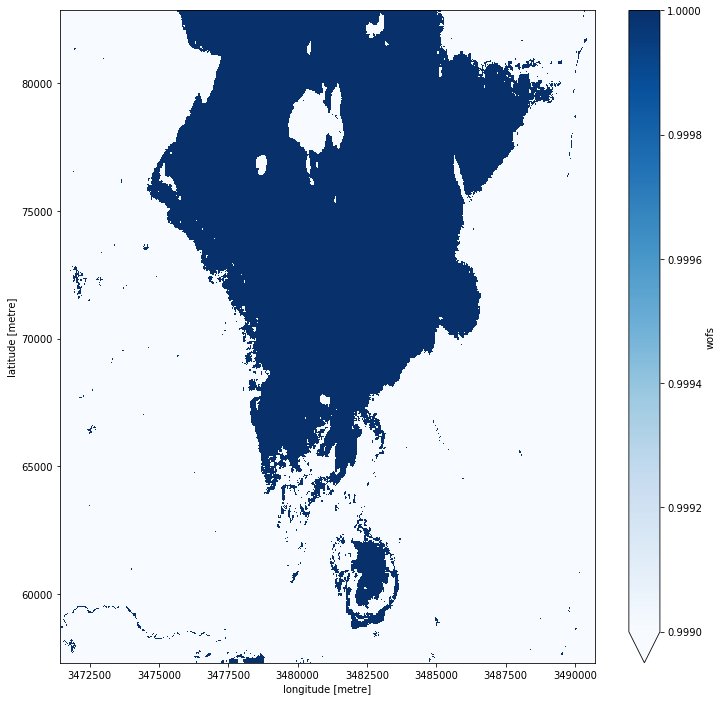

In [11]:
# Plot of WOFS product
# BLUE = 1.0 = Water
# WHITE = 0.0 = Non-Water

# Find the Maximum water extent for time period
water_max_extents = water_classification.max('time')

#plot maximum water extent
water_max_extents.wofs.plot(figsize=(12,12), cmap='Blues', vmin=0.999, vmax=1.0)

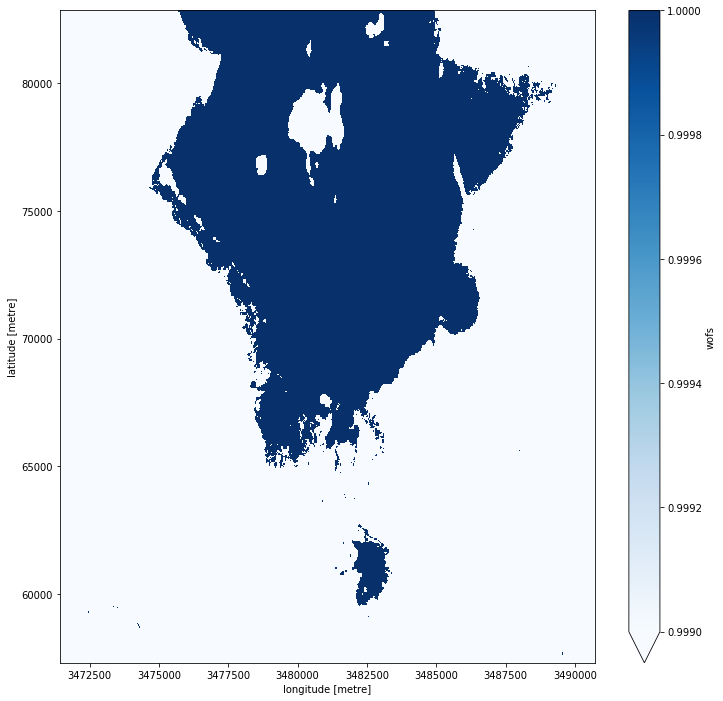

In [12]:
# generate Median water extent for time period by running classifier over median mosaic
water_classification_median = wofs_classify(land_and_water_composite, mosaic = True)

#plot median water extent
water_classification_median.wofs.plot(figsize=(12,12), cmap='Blues', vmin=0.999, vmax=1.0)

### WOFS Water Counts

In [13]:
# WOFS value for water = 0.0 or 1.0
# The threshold uses a range of 0.99 to 1.01 to identify water (1.0)

wofs_minimum_threshold = 0.99
wofs_maximum_threshold = 1.01

In [14]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))

In [15]:
# COUNT = number of pixels in each category
# INSIDE = Number of water pixels
# OUTSIDE = Number of NON water pixels
threshold_count(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold)

{'total': 20301456,
 'total_non_cloudy': 20301456,
 'inside': 4383694,
 'outside': 15917762}

In [16]:
# PERCENTAGE = percent of pixels in each category
threshold_percentage(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold)

{'percent_inside_threshold': 21.59300298461352,
 'percent_outside_threshold': 78.40699701538648,
 'percent_clouds': 0.0}

## GeoTIFF Output Products

<p style="color:red";><b>CHANGE INPUTS BELOW

In [17]:
#Save to Geotiff 
# Remove the comment to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 

Output_dataset = water_max_extents #Change dataset here to save different output

#add attributes back to median dataset due to numpy bug
Output_dataset.attrs = land_and_water_dataset.attrs
Output_dataset = Output_dataset.rename(name_dict={'longitude':'x','latitude':'y'}) #change coordinate names back in order to save to geotiff

#set output directory, if it dosn't exist create
output_dir = '../output/geotiffs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
#Set file name
# Change the name of the output file, or it will be overwritten for each run 
output_filename =  output_dir + '/DEMO_median_WOFS_extent.tif' 
    
#run command to save to file
#write_geotiff(output_filename, Output_dataset)  ##REMOVE COMMENT TO SAVE TO FILE


## Notes on modifications made moving from ARDC to DE Africa

- Replace dc.load fuction with DE Africa load
- Move all module imports to start of notebook
- Removed code to view extent of datacube replaced with mapviewer that can be used to visualise spatial extent of data
- Removed code to classify a median image with Fractional Cover, becasue it did not seem to relate to the rest of the workflow in the notebook
- replaced save to geotiff fuction with DE Africa fuction